In [3]:
# Bildirimleri kapat
import warnings
warnings.filterwarnings('ignore')

# Gerekli kütüphaneler
import os
import glob as gb
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer

# Veri Ön İşleme

Bu bölümde balık resimlerinin bulunduğu veri seti işlenmektedir.

1. **Ana Dizin Belirleme**: Balık resimlerinin bulunduğu dizin tanımlanır.
2. **Görüntü Dosyalarını Bulma**: İlgili görüntülerin tam yolları bir listeye eklenir.
3. **Etiketleri Çıkarma**: Dosya yollarından etiketler çıkarılır.
4. **DataFrame Oluşturma**: Görüntü dosya yolları ve etiketler bir DataFrame'e dönüştürülür.
5. **Veri Temizleme**: "GT" ile biten etiketler kaldırılır.
6. **Veri Karıştırma**: DataFrame rastgele olarak karıştırılır.
7. **Sınıf Sayısını Gruplandırma**: Her balık türü için görüntü sayısı gruplandırılır.
8. **Toplam Görüntü Sayısı**: Toplam görüntü ve klasör sayısı yazdırılır.


In [4]:
# Balık resimlerinin bulunduğu ana dizin
fish_path = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

# Görüntü dosyalarını bulma
filepaths = list(fish_path.glob(r'**/*.png'))

# Etiketleri dosya yolundan çıkarma (bir üst klasörü etiket olarak kullanıyoruz)
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Filepaths ve etiketleri pandas serisi olarak oluşturma
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
Labels = pd.Series(Labels, name='Label').astype(str)

# Filepath ve Label'ları birleştirme
image_df = pd.merge(filepaths, Labels, right_index=True, left_index=True)

# "GT" ile biten etiketleri kaldırma
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

# Resampling (karıştırma)
image_df = image_df.sample(frac=1).reset_index(drop=True)

# Her bir balık türü için kaç resim olduğunu gruplandırarak sayma
class_count = image_df.groupby('Label').count().reset_index()
class_count.columns = ['Fish Species', 'Image Count']

# Toplam klasör sayısı (etiketler bazında benzersiz türler)
total_folders = image_df['Label'].nunique()

# Toplam resim sayısı
total_images = image_df.shape[0]

# Resim ve klasör bilgilerini yazdırma
print("Her bir tür için bulunan resim sayısı:\n", class_count)
print(f"\nToplam klasör sayısı: {total_folders}")
print(f"Toplam resim sayısı: {total_images}")

Her bir tür için bulunan resim sayısı:
          Fish Species  Image Count
0     Black Sea Sprat         1000
1     Gilt-Head Bream         1000
2     Hourse Mackerel         1000
3          Red Mullet         1000
4       Red Sea Bream         1000
5            Sea Bass         1000
6              Shrimp         1000
7  Striped Red Mullet         1000
8               Trout         1000

Toplam klasör sayısı: 9
Toplam resim sayısı: 9000


# Balık Türlerine Göre Sınıfsal Dağılım

1. **Frekansların Hesaplanması**: Her balık türüne ait görüntü sayısını toplam görüntü sayısına bölüp yüzde olarak gösteriyoruz.

2. **Yüzde Hesaplama**: `fish_frequencies = (fish_counts / len(image_df)) * 100` satırı ile bu yüzdeleri hesaplıyoruz.

3. **İki Ayrı Grafik**:
    - İlk grafik, balık türlerine göre görüntü sayısını gösteriyor.
    - İkinci grafik, balık türlerine göre yüzdesel frekansı gösteriyor.

4. **Sonuç Tablosu**: `fish_distribution_df` adlı veri çerçevesi, her balık türünün görüntü sayısı ve frekansını içeriyor.

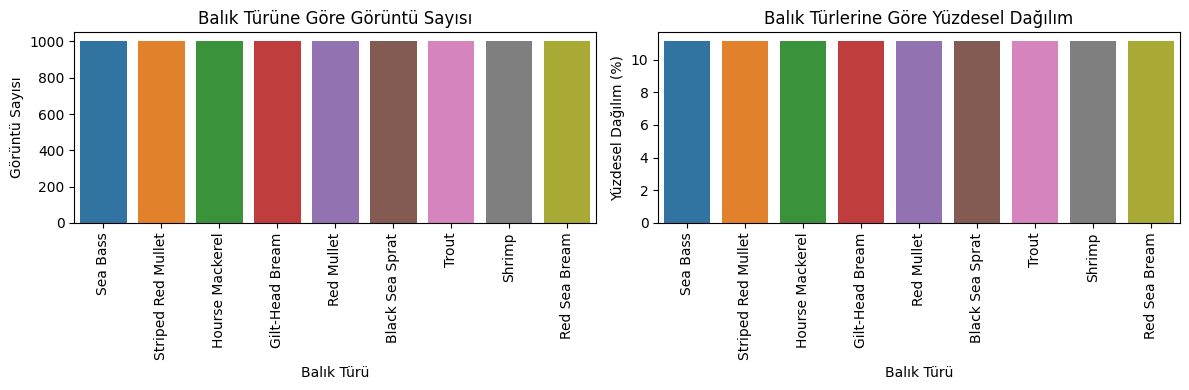

                    Count  Frequency (%)
Label                                   
Sea Bass             1000      11.111111
Striped Red Mullet   1000      11.111111
Hourse Mackerel      1000      11.111111
Gilt-Head Bream      1000      11.111111
Red Mullet           1000      11.111111
Black Sea Sprat      1000      11.111111
Trout                1000      11.111111
Shrimp               1000      11.111111
Red Sea Bream        1000      11.111111


In [5]:
# Balık türlerinin sayısal dağılımı
fish_counts = image_df['Label'].value_counts()

# Balık türlerine göre yüzdesel dağılım
fish_frequencies = (fish_counts / len(image_df)) * 100

# Sınıf dağılımını gösteren DataFrame
fish_distribution_df = pd.DataFrame({'Count': fish_counts, 'Frequency (%)': fish_frequencies})

# Sınıfsal dağılım grafikleri
plt.figure(figsize=(12, 4))

# Balık türüne göre görüntü sayısı
plt.subplot(1, 2, 1)
sns.barplot(x=fish_counts.index, y=fish_counts.values)
plt.xticks(rotation=90)
plt.title('Balık Türüne Göre Görüntü Sayısı')
plt.xlabel('Balık Türü')
plt.ylabel('Görüntü Sayısı')

# Balık türüne göre yüzdesel dağılım
plt.subplot(1, 2, 2)
sns.barplot(x=fish_frequencies.index, y=fish_frequencies.values)
plt.xticks(rotation=90)
plt.title('Balık Türlerine Göre Yüzdesel Dağılım')
plt.xlabel('Balık Türü')
plt.ylabel('Yüzdesel Dağılım (%)')

plt.tight_layout()
plt.show()

# Sonuçları yazdır
print(fish_distribution_df)

# Fotoğrafların Piksel Değerlerinin Analizi

Bu bölümde balık görüntülerinin piksel yoğunluk histogramları analiz edilmiştir.

1. **Tüm Piksel Değerlerinin Dağılımı**: İlk 10 görüntüdeki tüm piksellerin birleşik dağılımını 0-1 aralığında gösteriyoruz.

2. **Histogram Çizimi**: Veri setindeki ilk 10 görüntü için gri tonlamalı histogramlar oluşturulur. Her histogram, piksel değerlerinin frekansını gösterir.

3. **Grafiklerin Görselleştirilmesi**: Her görüntü için ayrı bir grafik oluşturularak, görüntü etiketleri başlık olarak belirtilir.

4. **Piksel Değerleri Analizi**: Histogramlar, görüntülerin piksel dağılımını anlamak için kullanılır; bu, görüntülerin aydınlık ve karanlık bölgelerinin yoğunluğunu ortaya çıkarır.

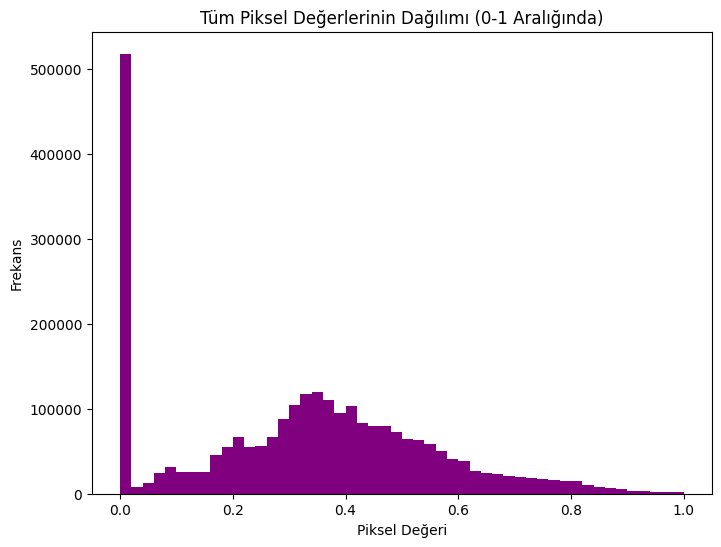

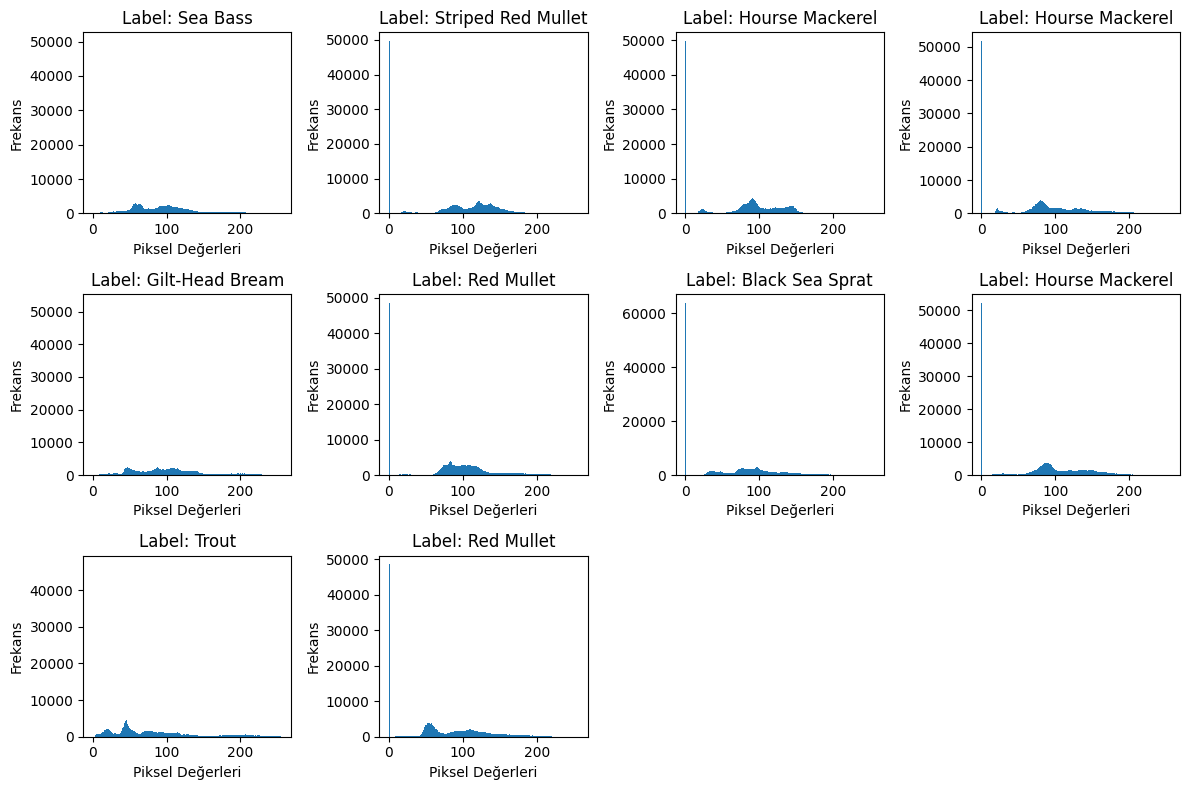

In [6]:
all_pixels = []  # Tüm piksel değerlerini biriktirmek için boş liste başlatılır

# İlk 10 görüntü üzerinde döngü
for idx, row in image_df.head(10).iterrows():  # Sadece ilk 10 görüntüyü döner
    img_path = row['Filepath']  # Görüntü dosyasının yolunu al
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Görüntüyü gri tonlamada oku

    # Görüntünün yüklenip yüklenmediğini kontrol et
    if img is None:
        print(f"Error: Unable to load image at {img_path}")  # Hata mesajı
        continue  # Hata varsa bu görüntüyü atla

    img_normalized = img / 255.0  # Piksel değerlerini 0-1 aralığında normalleştir
    all_pixels.extend(img_normalized.ravel())  # Tüm piksel değerlerini listeye ekle

# İlk 10 görüntünün piksel değerlerinin 0-1 aralığında birleştirilmiş hali
X = np.array(all_pixels)  # Piksel değerlerini bir numpy dizisine dönüştür

# Piksel değerlerinin dağılımını görselleştirme
plt.figure(figsize=(8, 6))
plt.hist(X.flatten(), bins=50, color='purple')  # Histogram
plt.title('Tüm Piksel Değerlerinin Dağılımı (0-1 Aralığında)')
plt.xlabel('Piksel Değeri')
plt.ylabel('Frekans')
plt.show()

# Her bir görüntü için piksel yoğunluk histogramlarını çizme
plt.figure(figsize=(12, 8))  # Tüm histogramlar için tek bir figür
for idx, row in image_df.head(10).iterrows():
    img = cv2.imread(row['Filepath'], cv2.IMREAD_GRAYSCALE)  # Görüntüyü tekrar oku
    if img is None:
        continue  # Hata varsa bu görüntüyü atla
    
    plt.subplot(3, 4, idx + 1)  # Alt grafik için yer ayır
    plt.title(f"Label: {row['Label']}")
    plt.hist(img.ravel(), bins=256, range=[0, 256])
    plt.xlabel('Piksel Değerleri')
    plt.ylabel('Frekans')

plt.tight_layout()  # Alt grafiklerin düzenini ayarla
plt.show()  # Tüm grafikleri göster

# Veri Setini Eğitim, Doğrulama ve Test Setlerine Bölme Fonksiyonu

Bu bölümde, veri setinin eğitim, doğrulama ve test setlerine bölünmesi için bir fonksiyon tanımlanmaktadır.

1. **Fonksiyon Tanımı**: `split_data` fonksiyonu, veri çerçevesini belirtilen oranlara göre eğitim, doğrulama ve test setlerine böler.
   - `train_ratio`: Eğitim setinin oranı (varsayılan %75).
   - `validation_ratio`: Doğrulama setinin oranı (varsayılan %10).
   - `test_ratio`: Test setinin oranı (varsayılan %15).

2. **Eğitim ve Test Verileri**: İlk olarak, eğitim ve test verileri `train_test_split` fonksiyonu kullanılarak ayrılır.

3. **Doğrulama ve Test Verileri**: Ardından, kalan test verileri doğrulama ve test setlerine yeniden bölünür.

4. **Sonuçların Yazdırılması**: Bölünmüş veri setlerinin boyutları ekrana yazdırılır.


In [7]:
# Veri setini eğitim, doğrulama ve test setlerine bölme fonksiyonu
def split_data(df, train_ratio=0.75, validation_ratio=0.10, test_ratio=0.15):
    # Eğitim ve test verilerini ayırma
    x_train, x_test = train_test_split(df, test_size=1 - train_ratio, random_state=42, shuffle=True)
    # Test verilerini doğrulama ve test verilerine ayırma
    x_val, x_test = train_test_split(x_test, test_size=test_ratio / (test_ratio + validation_ratio), random_state=42)
    return x_train, x_val, x_test  # Bölünmüş veri setlerini döndür

# Veri bölme işlemi
x_train, x_val, x_test = split_data(image_df)

# Verilerin boyutlarını yazdırma
print(f'Eğitim verisi boyutu: {x_train.shape}')  # Eğitim verisi boyutu
print(f'Doğrulama verisi boyutu: {x_val.shape}')  # Doğrulama verisi boyutu
print(f'Test verisi boyutu: {x_test.shape}')  # Test verisi boyutu

Eğitim verisi boyutu: (6750, 2)
Doğrulama verisi boyutu: (900, 2)
Test verisi boyutu: (1350, 2)


# Görüntü Ön İşleme ve Veri Artırma Ayarları

Bu bölümde, görüntü ön işleme ve veri artırma ayarları yapılmaktadır.

1. **Görüntü Boyutu ve Batch Boyutu**:
   - `img_size`: Görüntü boyutu olarak (224, 224) ayarlandı.
   - `batch_size`: Batch boyutu olarak 32 belirlendi.

2. **Veri Artırma İşlemleri**: Görüntüleri dönüştürme, zoom, yatay çevirme gibi işlemler tanımlandı.
   - `ImageDataGenerator`: 
     - `preprocessing_function`: Mobilenet V2 için ön işleme.
     - `rotation_range`: Rastgele döndürme aralığı 30 derece.
     - `zoom_range`: Rastgele zoom aralığı %20.
     - `horizontal_flip`: Yatay çevirme.
     - `width_shift_range` ve `height_shift_range`: Genişlik ve yükseklik kaydırma %10.

3. **Veri Akışlarını Oluşturma**: 
   - `create_data_flow` fonksiyonu, DataFrame'den veri akışlarını oluşturur. 
   - Görüntü dosyası yolu `x_col`, etiket `y_col`, ve diğer parametreler ile veri akışları oluşturulur.

4. **Veri Akışlarının Oluşturulması**: Eğitim, test ve doğrulama veri setleri için veri akışları oluşturuldu:
   - `train_generator`: Eğitim verisi akışı.
   - `val_generator`: Doğrulama verisi akışı.
   - `test_generator`: Test verisi akışı.

5. **Kontrol**: Sınıf dağılımları yazdırılarak kontrol edildi.


In [8]:
# Görüntü ön işleme ve veri artırma ayarları
img_size = (224, 224)  # Görüntü boyutu
batch_size = 32  # Batch boyutu

# Veri artırma işlemleri: Görüntüleri dönüştürme, zoom, yatay çevirme gibi işlemler ekledik
img_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,  # Mobilenet V2 için ön işleme
    rotation_range=30,  # Rastgele döndürme aralığı
    zoom_range=0.2,  # Rastgele zoom aralığı
    horizontal_flip=True,  # Yatay çevirme
    width_shift_range=0.1,  # Genişlik kaydırma
    height_shift_range=0.1  # Yükseklik kaydırma
)

# DataFrame'den veri akışlarını oluşturma fonksiyonu
def create_data_flow(dataframe, datagen, img_size, batch_size):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,  # DataFrame
        x_col='Filepath',  # Görüntü dosyası yolu
        y_col='Label',  # Etiket
        target_size=img_size,  # Hedef görüntü boyutu
        color_mode='rgb',  # Renk modu
        class_mode='categorical',  # Sınıf modu
        batch_size=batch_size,  # Batch boyutu
        seed=42,  # Rastgelelik için tohum
        shuffle=True  # Verileri karıştırma
    )

# Eğitim, test ve doğrulama veri setleri için veri akışlarını oluşturma
train_generator = create_data_flow(x_train, img_datagen, img_size, batch_size)  # Eğitim verisi akışı
val_generator = create_data_flow(x_val, img_datagen, img_size, batch_size)  # Doğrulama verisi akışı
test_generator = create_data_flow(x_test, img_datagen, img_size, batch_size)  # Test verisi akışı

# Kontrol: Sınıf dağılımlarını yazdır
print(f"Class distribution in training set: {x_train['Label'].value_counts()}")  # Eğitim seti sınıf dağılımı
print()
print(f"Class distribution in validation set: {x_val['Label'].value_counts()}")  # Doğrulama seti sınıf dağılımı
print()
print(f"Class distribution in testing set: {x_test['Label'].value_counts()}")  # Test seti sınıf dağılımı

Found 6750 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Class distribution in training set: Label
Shrimp                769
Red Mullet            754
Gilt-Head Bream       754
Trout                 753
Hourse Mackerel       752
Sea Bass              751
Red Sea Bream         748
Striped Red Mullet    746
Black Sea Sprat       723
Name: count, dtype: int64

Class distribution in validation set: Label
Black Sea Sprat       109
Hourse Mackerel       106
Gilt-Head Bream       105
Trout                  99
Red Mullet             98
Red Sea Bream          97
Striped Red Mullet     96
Sea Bass               96
Shrimp                 94
Name: count, dtype: int64

Class distribution in testing set: Label
Black Sea Sprat       168
Striped Red Mullet    158
Red Sea Bream         155
Sea Bass              153
Red Mullet            148
Trout                 148
Hourse Macker

# One-Hot Encoded Etiketlerinin Görselleştirilmesi
1. **Etiketlerin One-Hot Encode Edilmesi**:
One-hot encoding, her sınıf için ayrı bir sütun ekleyerek, doğru sınıfa 1, diğerlerine 0 verir. Bu adımda, balık türleri için one-hot encoded etiketler oluşturuyoruz.

2. **Görselleştirme**:
Bir balık türüne ait örneklerin one-hot encoded etiketlerinin nasıl bir formda olduğunu göstermek için heatmap (ısıl harita) kullanıyoruz. Her bir etiket, bir satır olarak temsil edilir ve her sınıfın 0 veya 1 değeri ile işaretlenmesi görselleştirilir.

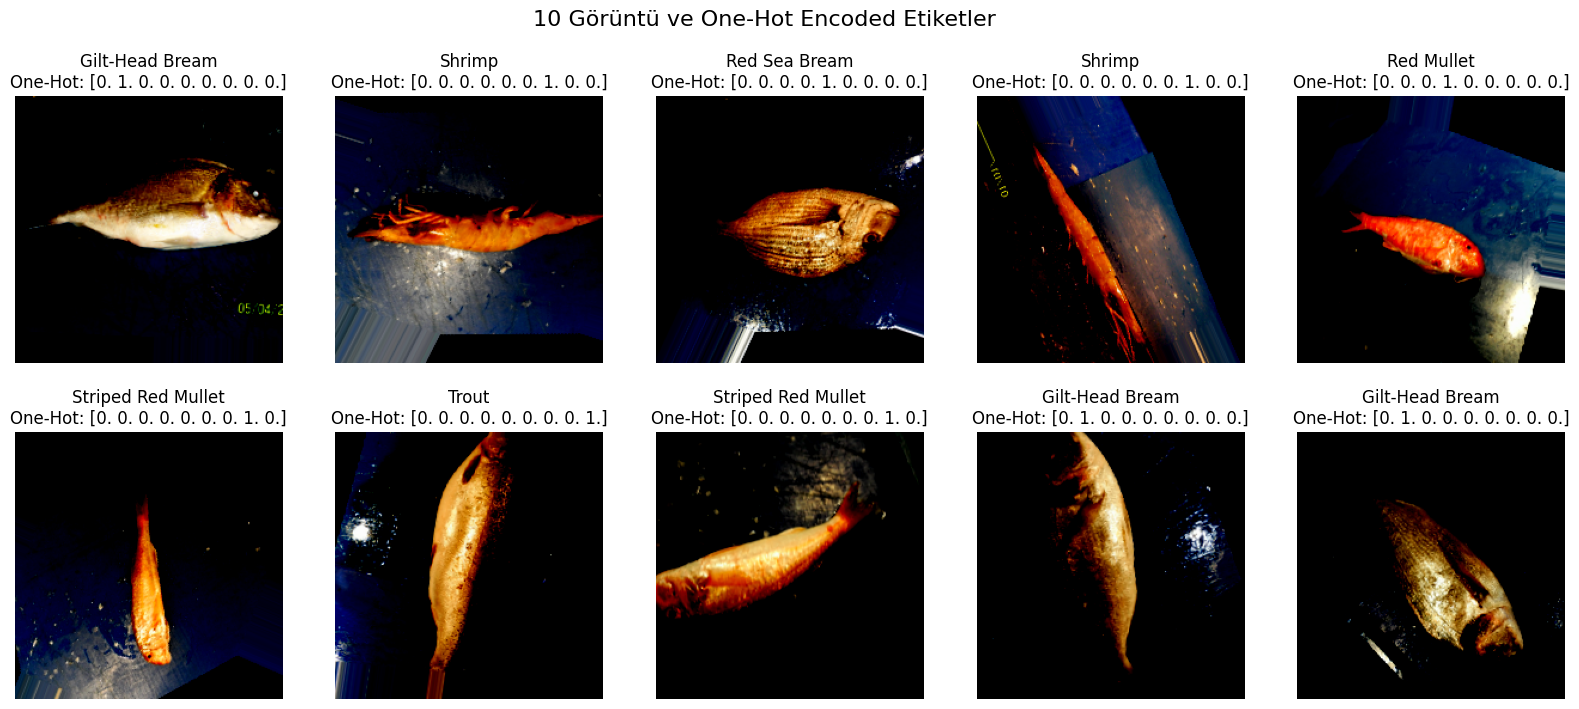

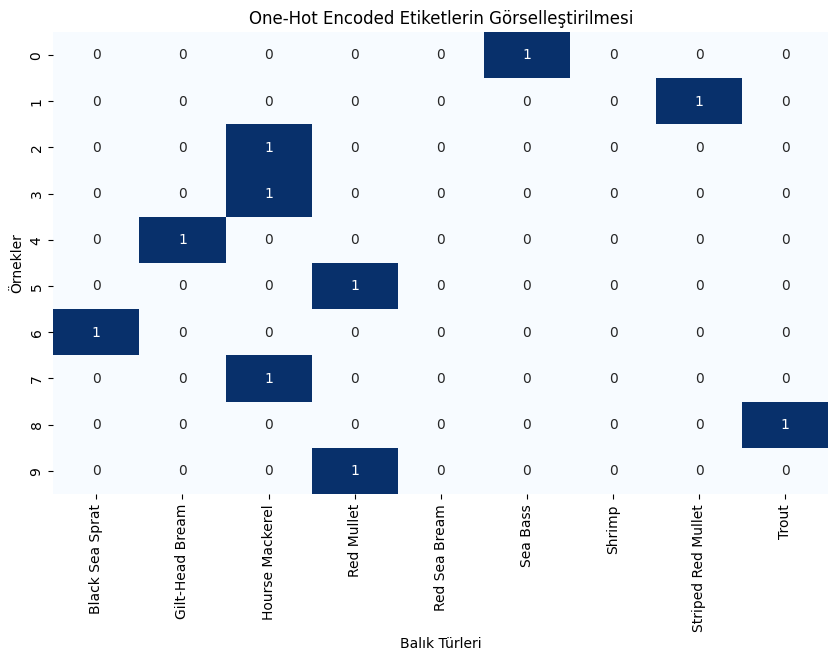

In [9]:
# One-hot encode etiketleri oluştur
encoder = LabelBinarizer()
one_hot_labels = encoder.fit_transform(image_df['Label'])

# Eğitim setinden rastgele 10 görüntü seç
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('10 Görüntü ve One-Hot Encoded Etiketler', fontsize=16)

for i in range(10):
    # Rastgele bir batch numarası seç
    random_batch_index = random.randint(0, train_generator.n // train_generator.batch_size - 1)
    
    # Seçilen batch'i al
    images, labels = train_generator[random_batch_index]
    
    # Rastgele bir görüntü ve etiketi seç
    random_image_index = random.randint(0, len(images) - 1)
    image = images[random_image_index]
    label = labels[random_image_index]
    
    # One-hot encoded etiketin hangi sınıfa karşılık geldiğini bul
    label_index = np.argmax(label)
    label_name = list(train_generator.class_indices.keys())[label_index]

    # Görüntüyü ve etiketi yerleştir
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title(f'{label_name}\nOne-Hot: {label}')
    ax.axis('off')
    
# Göster
plt.show()

# İlk 10 veriyi görselleştirelim
plt.figure(figsize=(10, 6))
sns.heatmap(one_hot_labels[:10], annot=True, cmap='Blues', cbar=False, xticklabels=encoder.classes_)
plt.title('One-Hot Encoded Etiketlerin Görselleştirilmesi')
plt.xlabel('Balık Türleri')
plt.ylabel('Örnekler')
plt.show()

# Görüntü Sınıflandırma için Model

Bu yapay sinir ağı modeli, 224x224 boyutundaki RGB görüntüleri kullanarak 9 farklı sınıfı sınıflandırmak için tasarlanmıştır.

## Model Yapısı
- **Giriş Katmanı:**  
  - Görüntüler 0-1 aralığına ölçeklendirilir.

- **Gizli Katmanlar:**  
  - İlk katman: `Flatten` ile görüntüler düzleştirilir.  
  - Birinci gizli katman: 512 nöron ve `ReLU` aktivasyonu.  
  - %20 Dropout ile overfitting'i önleme.  
  - İkinci gizli katman: 512 nöron ve `ReLU` aktivasyonu.  
  - %20 Dropout ile ek overfitting önlemi.  

- **Çıkış Katmanı:**  
  - 9 sınıf için `Softmax` aktivasyon fonksiyonuna sahip çıkış katmanı.

## Derleme ve Eğitim
- **Optimizasyon Algoritması:**  
  Adam optimizasyon algoritması ile model eğitimi yapılır.

- **Kayıp Fonksiyonu:**  
  Çoklu sınıf sınıflandırma için `Categorical Crossentropy` kullanılır.

- **Metrik:**  
  Doğruluk (`Accuracy`) metriği, modelin performansını ölçmek için kullanılır.

- **Sınıf Ağırlıkları:**  
  Dengesiz sınıfları dengelemek için `class_weight` ile sınıf ağırlıkları hesaplanır ve modele verilir.

- **Erken Durdurma (EarlyStopping):**  
  - 5 epoch boyunca doğrulama kaybı (`val_loss`) iyileşmezse eğitim durdurulur ve en iyi ağırlıklar geri yüklenir.

## Eğitim Ayarları
- **Epoch Sayısı:**  
  Model 10 epoch boyunca eğitilir. 


In [10]:
# Modeli oluşturma
model = Sequential()

# Giriş katmanı
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)))  # Görüntüleri 0-1 aralığına ölçekleme

# Gizli katmanlar
model.add(Flatten())  # Görüntüleri düzleştir
model.add(Dense(512, activation='relu'))  # Birinci gizli katman
model.add(Dropout(0.2))  # Overfitting'i önlemek için Dropout
model.add(Dense(512, activation='relu'))  # İkinci gizli katman
model.add(Dropout(0.2))  # Overfitting'i önlemek için Dropout

# Çıkış katmanı (9 sınıf için)
model.add(Dense(9, activation='softmax'))  # Softmax aktivasyonu ile çıkış katmanı

# Modeli derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin özeti
model.summary()

# Sınıf ağırlıklarını hesaplama
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(test_generator.classes),
                                                  y=test_generator.classes)
# Sınıf ağırlıklarını sözlüğe dönüştürme
class_weights_dict = dict(enumerate(class_weights))

# EarlyStopping ayarı
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modeli eğitme
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=10, 
                    class_weight=class_weights_dict, 
                    callbacks=[early_stopping])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,338,121 (295.02 MB)

 Trainable params: 77,338,121 (295.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.2610 - loss: 1.9465 - val_accuracy: 0.4081 - val_loss: 1.5727
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.4146 - loss: 1.5681 - val_accuracy: 0.4422 - val_loss: 1.4761
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.4418 - loss: 1.4702 - val_accuracy: 0.5385 - val_loss: 1.2840
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.5036 - loss: 1.3622 - val_accuracy: 0.5607 - val_loss: 1.2212
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.5307 - loss: 1.2774 - val_accuracy: 0.5659 - val_loss: 1.1627
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.5491 - loss: 1.2043 - val_accuracy: 0.6030 - val_loss: 1.0868
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.5756 - loss: 1.1443 - val_accuracy: 0.6244 - val_loss: 1.0206
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.6191 - loss: 1.0415 - val_accu

# Modelin Değerlendirilmesi

Bu bölümde modelin eğitim ve doğrulama sürecinde elde edilen kayıp (loss) ve doğruluk (accuracy) değerleri görselleştirilmektedir:

1. **Kayıp Fonksiyonu**:
   - Eğitim kaybı ve doğrulama kaybı `plt.plot()` fonksiyonu ile çizilir.
   - Her bir epoch için kayıp değerleri üzerinde metin ile kayıp yüzdeleri gösterilir.

2. **Doğruluk**:
   - Eğitim doğruluğu ve doğrulama doğruluğu benzer şekilde çizilir.
   - Her bir epoch için doğruluk yüzdeleri de metin ile gösterilir.

3. **Görselleştirme**:
   - Tüm grafikler 12x4 boyutlarında bir figürde yan yana yerleştirilir.
   - Kayıp ve doğruluk değerleri için başlıklar, x ve y eksenleri etiketlenir.
   - En son değerler print ile ekrana yazdırılır.

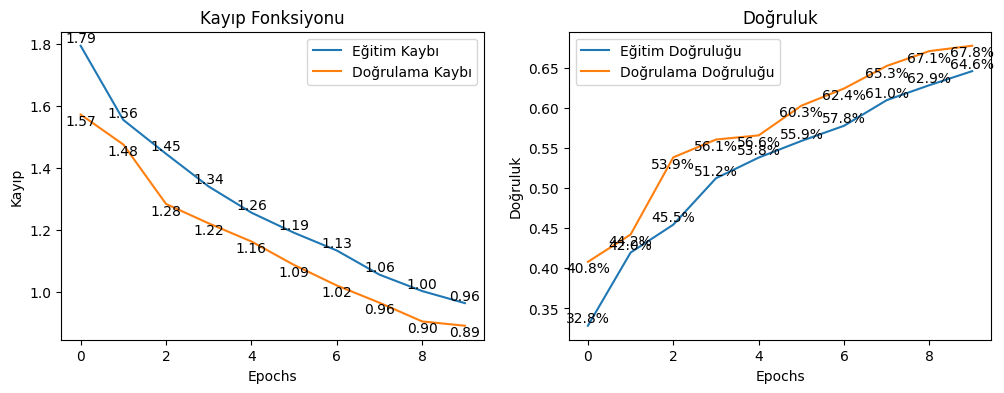

Son Eğitim Kaybı: 0.9637
Son Doğrulama Kaybı: 0.8907
Son Eğitim Doğruluğu: 64.61%
Son Doğrulama Doğruluğu: 67.78%


In [11]:
# Modelin Değerlendirilmesi
# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.title('Kayıp Fonksiyonu')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')

# Kayıp yüzdelerini göster
for i in range(len(history.history['loss'])):
    plt.text(i, history.history['loss'][i], f"{history.history['loss'][i]:.2f}", ha='center', va='bottom')
    plt.text(i, history.history['val_loss'][i], f"{history.history['val_loss'][i]:.2f}", ha='center', va='top')

# Eğitim ve doğrulama doğruluklarını çizme
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.title('Doğruluk')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')

# Doğruluk yüzdelerini göster
for i in range(len(history.history['accuracy'])):
    plt.text(i, history.history['accuracy'][i], f"{history.history['accuracy'][i] * 100:.1f}%", ha='center', va='bottom')
    plt.text(i, history.history['val_accuracy'][i], f"{history.history['val_accuracy'][i] * 100:.1f}%", ha='center', va='top')

plt.show()

# Son eğitim ve doğrulama değerlerini yazdırma
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Son Eğitim Kaybı: {final_train_loss:.4f}")
print(f"Son Doğrulama Kaybı: {final_val_loss:.4f}")
print(f"Son Eğitim Doğruluğu: {final_train_accuracy * 100:.2f}%")
print(f"Son Doğrulama Doğruluğu: {final_val_accuracy * 100:.2f}%")

# Hiperparametre Optimizasyonu

### Başlangıç Parametreleri:
- **Yoğun Katman (Dense)**: 128 nöron
- **Dropout Oranı**: 0.2

Başlangıç hiperparametreleriyle modelin elde ettiği sonuçlar:
- **Son Eğitim Kaybı**: 1.042
- **Son Doğrulama Kaybı**: 1.020
- **Son Eğitim Doğruluğu**: 61.50%
- **Son Doğrulama Doğruluğu**: 58.20%

### Hiperparametre Değişiklikleri:
Performansı artırmak için iki önemli değişiklik yapıldı:
1. Yoğun katmandaki nöron sayısı artırıldı.
2. Dropout oranı korundu.

### Yeni Parametreler:
- **Yoğun Katman (Dense)**: 512 nöron (iki adet)
- **Dropout Oranı**: 0.2

Yapılan bu hiperparametre değişiklikleri sonucunda modelin performansında iyileşme gözlendi. Yeni hiperparametreler ile modelin eğitim ve doğrulama sonuçları aşağıdaki gibidir:

- **Son Eğitim Kaybı**: 0.9637
- **Son Doğrulama Kaybı**: 0.8907
- **Son Eğitim Doğruluğu**: 64.61%
- **Son Doğrulama Doğruluğu**: 67.78%


# Confusion Matrix ve Classification Report

Bu bölümde, modelin test veri seti üzerindeki performansı, confusion matrix (karışıklık matrisi) ve classification report (sınıflandırma raporu) ile değerlendirilmektedir.

## 1. Gerçek ve Tahmin Edilen Etiketlerin Alınması
- Gerçek etiketler `test_generator.classes` ile alınır.
- Model tarafından tahmin edilen etiketler, `model.predict(test_generator)` ile elde edilir ve `np.argmax()` fonksiyonu ile sınıflar arasından en yüksek olasılığa sahip olanı seçilerek belirlenir.

## 2. Confusion Matrix
- Confusion matrix, `confusion_matrix` fonksiyonu kullanılarak oluşturulur.
- Matris, modelin doğru ve yanlış tahminlerini görsel olarak temsil eder.
- Her bir sınıf için doğru tahminlerin sayısı ve diğer sınıflara yapılan yanlış tahminler gösterilir.

### Görselleştirme
- Matris, `plt.imshow()` ile görselleştirilir ve renkli bir harita ile kullanıcıya sunulur.
- X ve Y eksenlerinde gerçek ve tahmin edilen etiketler yer alır.

## 3. Classification Report
- `classification_report` fonksiyonu kullanılarak modelin sınıf bazında precision (kesinlik), recall (duyarlılık) ve f1-score değerleri hesaplanır.
- Rapor, modelin her bir sınıf için başarımını detaylı bir şekilde sunar.

43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 756ms/step


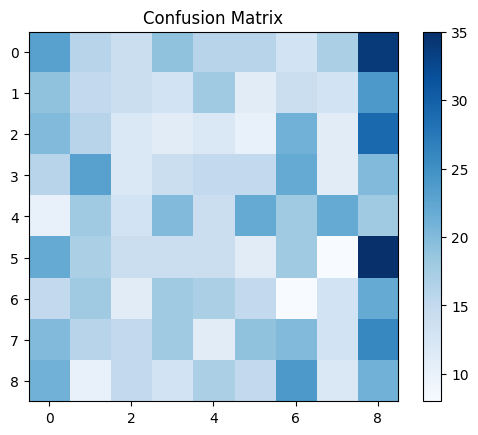

                    precision    recall  f1-score   support

   Black Sea Sprat       0.14      0.14      0.14       168
   Gilt-Head Bream       0.10      0.11      0.10       141
   Hourse Mackerel       0.10      0.08      0.09       142
        Red Mullet       0.10      0.09      0.10       148
     Red Sea Bream       0.10      0.09      0.10       155
          Sea Bass       0.08      0.07      0.08       153
            Shrimp       0.05      0.06      0.05       137
Striped Red Mullet       0.11      0.08      0.09       158
             Trout       0.09      0.14      0.11       148

          accuracy                           0.10      1350
         macro avg       0.10      0.10      0.10      1350
      weighted avg       0.10      0.10      0.10      1350



In [12]:
# Test veri seti üzerinde tahmin yap
test_generator.reset()
preds = model.predict(test_generator)
predicted_classes = np.argmax(preds, axis=1)

# Confusion matrix
cm = confusion_matrix(test_generator.classes, predicted_classes)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# Classification report
print(classification_report(test_generator.classes, predicted_classes, target_names=test_generator.class_indices.keys()))

# Tahmin Görselleştirme Fonksiyonu

Modelin tahmin sonuçlarını görselleştirmek için bir fonksiyon tanımlanmıştır. Bu fonksiyon, test setindeki belirli bir görüntüyü yükler, gerçek ve tahmin edilen etiketleri karşılaştırır. Aşağıdaki adımlar izlenir:

1. **Görüntü Yükleme**: `test_generator` kullanılarak görüntü dosyası yüklenir ve modelin beklediği boyutta (`224x224`) yeniden boyutlandırılır.

2. **Gerçek ve Tahmin Edilen Etiketlerin Alınması**: 
   - Gerçek etiket `test_generator.classes[ix]` ile alınır.
   - Tahmin edilen etiket `y_pred_classes[ix]` ile elde edilir.

3. **Sınıf İsimlerini Alma**: `class_indices` kullanılarak indekslere karşılık gelen etiket isimleri ters çevrilir.

4. **Görüntüyü Görselleştirme**: 
   - `matplotlib` kullanılarak yüklenen görüntü gösterilir.
   - Başlıkta gerçek ve tahmin edilen sınıf isimleri yer alır.

5. **Fonksiyonun Çağrılması**: Son olarak, belirtilen indeks ile tahmin sonuçlarını görselleştirmek için fonksiyon çağrılır.


43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 765ms/step


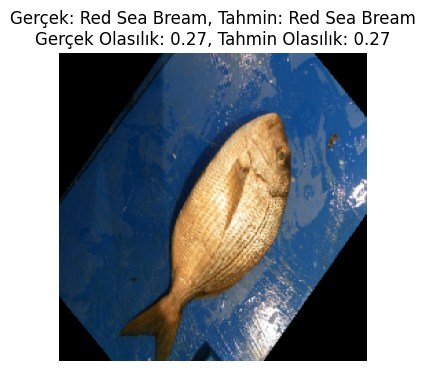

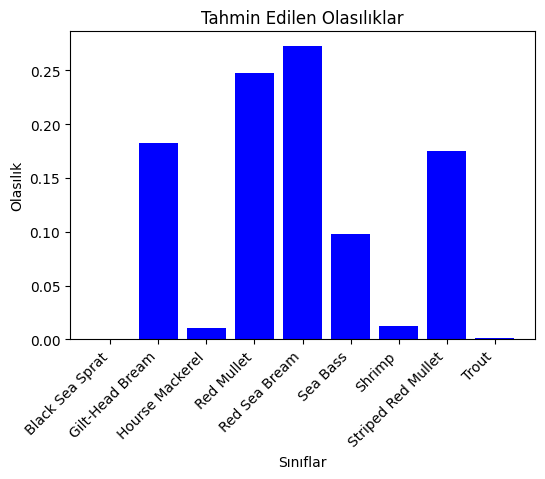

In [14]:
# Test seti üzerindeki tahminleri alalım
y_pred = model.predict(test_generator)

# Tahmin edilen sınıfları bulalım (en yüksek olasılığa sahip olan sınıf)
y_pred_classes = np.argmax(y_pred, axis=1)

# Rastgele bir indeksi otomatik olarak seçiyoruz:
ix = np.random.randint(0, len(test_generator.filepaths))

# Görselleştirme fonksiyonu
def plot_prediction(test_generator, y_pred_classes, y_pred, ix):
    # Test setindeki görüntüyü yükleyelim
    img_path = test_generator.filepaths[ix]
    img = load_img(img_path, target_size=(224, 224))  # Görüntü boyutu modeliyle uyumlu olmalı
    img_array = img_to_array(img)

    # Gerçek ve tahmin edilen sınıfları al
    true_label = test_generator.classes[ix]  # Gerçek etiket (integer)
    predicted_label = y_pred_classes[ix]  # Tahmin edilen etiket (integer)

    # class_indices'yi ters çevirerek indekslere karşılık gelen etiket isimlerini alıyoruz
    class_labels = {v: k for k, v in test_generator.class_indices.items()}  # Ters çevirme işlemi

    # Gerçek ve tahmin edilen sınıf isimlerini al
    true_class_name = class_labels[true_label]
    predicted_class_name = class_labels[predicted_label]

    # Görüntüyü görselleştirelim
    plt.figure(figsize=(6, 4))
    plt.imshow(img_array.astype('uint8'))
    plt.title(f"Gerçek: {true_class_name}, Tahmin: {predicted_class_name}\n"
              f"Gerçek Olasılık: {y_pred[ix][true_label]:.2f}, Tahmin Olasılık: {y_pred[ix][predicted_label]:.2f}")
    plt.axis('off')
    plt.show()

# Bar grafiği çizmek için fonksiyon (sınıfların olasılıklarını görselleştirme)
def plot_probability_graph(y_pred, ix, class_labels):
    prediction_probabilities = y_pred[ix]  # y_pred, her bir görüntü için tahmin edilen olasılıkları içermelidir

    # Bar grafiği oluştur
    plt.figure(figsize=(6, 4))
    plt.bar(list(class_labels.values()), prediction_probabilities, color='blue')
    plt.title('Tahmin Edilen Olasılıklar')
    plt.xlabel('Sınıflar')
    plt.ylabel('Olasılık')
    plt.xticks(rotation=45, ha='right')  # X etiketlerini döndür
    plt.show()

# Tahmin sonuçlarını görselleştirelim
plot_prediction(test_generator, y_pred_classes, y_pred, ix)

# Olasılık grafiğini görselleştirelim
class_labels = {v: k for k, v in test_generator.class_indices.items()}  # Sınıf etiketlerini almak için
plot_probability_graph(y_pred, ix, class_labels)
